# Variational Inference Tutorial: Handling Multimodal Data

In this tutorial, we'll explore how to perform Variational Inference (VI) on multimodal data. We'll start with a simple Gaussian approximation to understand its limitations, then move to a more flexible mixture model approach.

## 1. Setup and Data Generation
   
First, let's import the necessary libraries and generate some synthetic multimodal data.

In [30]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Define true parameters (centers of the mixture)
true_thetas = torch.tensor([[1.5, 2.0], [3.0, 1.0], [2.0, 3.0]])
weights = torch.tensor([0.4, 0.3, 0.3])

# Generate observations from mixture
n_samples = 100
sigma_true = 0.1

# Sample from mixture
mixture_indices = torch.multinomial(weights, n_samples, replacement=True)
observations = torch.zeros((n_samples, 2))
for i in range(n_samples):
    center = true_thetas[mixture_indices[i]]
    observations[i] = center + sigma_true * torch.randn(2)

Lets visualise the data 

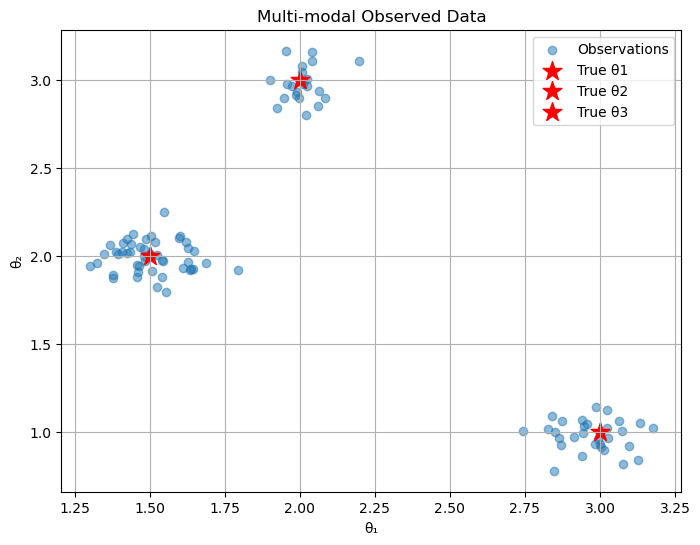

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(observations[:, 0], observations[:, 1], alpha=0.5, label='Observations')
for i, theta in enumerate(true_thetas):
    plt.scatter([theta[0]], theta[1], color='red', marker='*', s=200, label=f'True θ{i+1}')
plt.title('Multi-modal Observed Data')
plt.xlabel('θ₁')
plt.ylabel('θ₂')
plt.legend()
plt.grid(True)
plt.show()

## 2. Understanding the Posterior Landscape
Before we start with VI, let's visualize the posterior landscape to understand what we're trying to approximate.

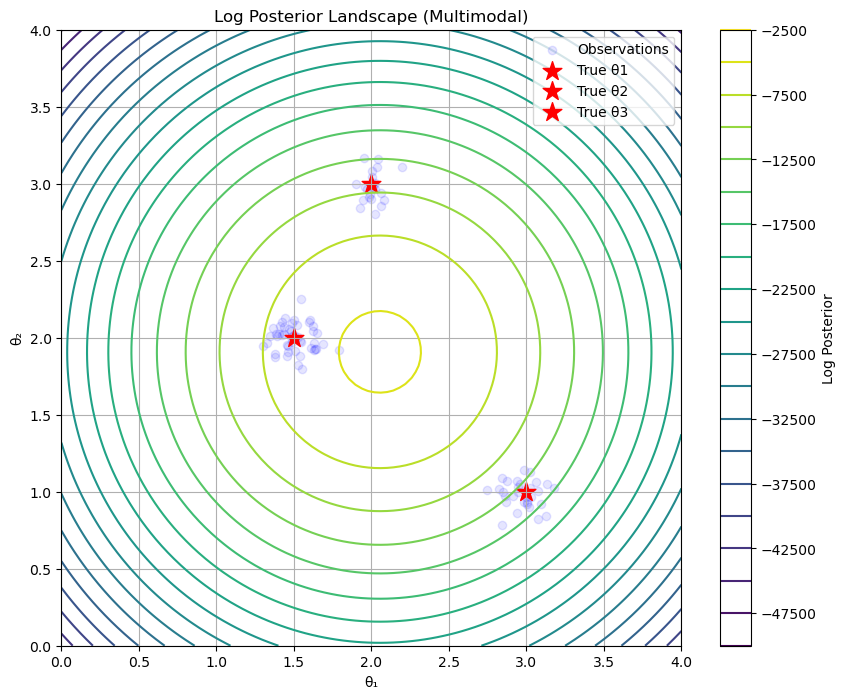

In [35]:
def log_likelihood_multimodal(theta, observations, sigma=0.1):
    """
    Log likelihood for multimodal case
    For each observation, we consider its likelihood under each mode
    """
    theta_expanded = theta.view(1, 2)
    log_likes = []
    
    for obs in observations:
        # Calculate squared distance
        dist = torch.sum((obs - theta_expanded)**2, dim=1)
        # Compute log likelihood for this observation
        log_like = -0.5 * dist / (sigma**2)
        log_likes.append(log_like)
    
    # Sum log likelihoods
    return torch.sum(torch.stack(log_likes))

def log_prior_multimodal(theta):
    """
    Modified prior that considers multiple modes
    Uses a mixture of Gaussians centered at the true modes
    """
    # Calculate distance to each mode
    distances = torch.stack([
        -0.5 * torch.sum((theta - true_theta)**2) / 0.5**2  # Increased variance
        for true_theta in true_thetas
    ])
    
    # Take the soft maximum (log sum exp)
    return torch.logsumexp(distances, dim=0)

# Create grid for posterior landscape
theta1 = np.linspace(0, 4, 100)
theta2 = np.linspace(0, 4, 100)
T1, T2 = np.meshgrid(theta1, theta2)
log_posterior = np.zeros_like(T1)

# Compute log posterior for each point
for i in range(T1.shape[0]):
    for j in range(T1.shape[1]):
        theta = torch.tensor([T1[i,j], T2[i,j]])
        log_posterior[i,j] = (log_likelihood(theta, observations) + 
                            log_prior(theta)).detach().numpy()

plt.figure(figsize=(10, 8))
plt.contour(T1, T2, log_posterior, levels=20)
plt.colorbar(label='Log Posterior')
plt.scatter(observations[:, 0], observations[:, 1], alpha=0.1, color='blue', 
           label='Observations')
for i, theta in enumerate(true_thetas):
    plt.scatter([theta[0]], theta[1], color='red', marker='*', s=200, 
               label=f'True θ{i+1}')
plt.title('Log Posterior Landscape (Multimodal)')
plt.xlabel('θ₁')
plt.ylabel('θ₂')
plt.legend()
plt.grid(True)
plt.show()